In [1]:
# ========= 标准库导入 =========
import os
import pickle
import random
import json
from datetime import datetime

# ========= 科学计算 & 数据处理 =========
import numpy as np
import pandas as pd
from scipy.stats import zscore
from scipy.optimize import linear_sum_assignment

# ========= 机器学习 & 统计 =========
from sklearn.metrics import roc_curve, auc, silhouette_score, adjusted_rand_score
from sklearn.cluster import KMeans

# ========= 深度学习 =========
import torch


# ========= 单细胞分析相关 =========
import anndata as ad
import scanpy as sc

# ========= 进度条 =========
from tqdm import tqdm

# ========= scReGAT 包 =========
from scregat import (
    SCReGAT,
    set_seed,
    train_model,
    test_model,
    get_gene_expression,
    get_edge_info,
    preprocess_graph,
)

/root/anaconda3/envs/scregat/lib/python3.10/site-packages/anndata/_metadata.py:15: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/root/anaconda3/envs/scregat/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
with open(
    "../data/Pancreas/External_Hi-C/C0027_dataset_atac_external_add_tf.pkl",
    "rb",
) as f:
    dataset_atac = pickle.load(f)

In [3]:
dataset_atac.list_graph[0]

Data(x=[31150, 1], edge_index=[2, 35914], y=[1], edge_tf=[5408, 2], y_exp=[1634], cell='C0027_AAACAGCCACACTAAT-1')

In [4]:
seed = 42
set_seed(seed)

num_epoch = 4
learning_rate = 1e-4
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
print(f"使用的设备: {device}")
batch_size = 8

model = SCReGAT()

使用的设备: cuda:2


In [5]:
test_barcode_file = "/remote-home/share/data2/dyn/scReGAT/Pancreas/External_Hi-C/test/output_external/test_barcode_epoch4_seed4_seed943.csv"
test_cell_barcodes = pd.read_csv(test_barcode_file, header=None, index_col=None)
test_cell_barcodes = test_cell_barcodes.loc[:, 0].values
len(test_cell_barcodes)

3017

In [ ]:
test_cell_barcodes

In [6]:
balanced_train_graph, test_graph = preprocess_graph(
    dataset_atac,
    test_cell_barcodes,
    max_random_sample=0,
    seed=seed,
    if_test=False,
    is_balances=False,
)

Preprocess Start!


Processing samples: 100%|██████████| 6034/6034 [00:00<00:00, 7427.66it/s]


train_graph: 3017
test_graph: 3017
random max_values: 5.391916275024414


Processing samples: 0it [00:00, ?it/s]

adding random nodes...: 0


In [7]:
# Prepare expression data
rna_adata_path = "/remote-home/share/data2/dyn/scReGAT/scReGAT_v2/ScMultiome_Pancreas/h5ad_data/C0027_rna_celltype.h5ad"
reference_rna_adata = sc.read_h5ad(rna_adata_path)
reference_rna_adata = reference_rna_adata[
    :, ~reference_rna_adata.var_names.duplicated()
]

# Get gene list, filtering out genes starting with 'chr'
filtered_gene_list = [t for t in dataset_atac.array_peak if not t.startswith("chr")]

# Get cell list
cell_barcodes = [t.cell for t in dataset_atac.list_graph]

# Convert gene list to numpy array and filter RNA data
filtered_gene_list = np.array(filtered_gene_list)
reference_rna_adata = reference_rna_adata[:, filtered_gene_list]

# Get expression matrix
expression_matrix = reference_rna_adata[cell_barcodes, :].X.toarray()
print(f"Expression matrix shape: {expression_matrix.shape}")

# Update graphs with expression data
updated_graphs = []
for idx, graph_data in tqdm(
    enumerate(dataset_atac.list_graph),
    total=len(dataset_atac.list_graph),
    desc="Processing graphs",
):
    graph_data.y_exp = torch.tensor(
        expression_matrix[idx, :] / np.sum(expression_matrix[idx, :]),
        dtype=torch.float32,
    )
    updated_graphs.append(graph_data)

model = train_model(
    model,
    balanced_train_graph,
    num_epoch=num_epoch,
    batch_size=batch_size,
    lr=learning_rate,
    max_grad_norm=1.0,
    sparse_loss_weight=0.1,
    if_zero=False,
    use_device=device,
)

Expression matrix shape: (6034, 1634)


Epoch 1/4: 100%|██████████| 378/378 [05:04<00:00,  1.24batch/s, loss=0.635, loss1=0.428, sparse_loss=0.207]


Epoch [1/4], Average Loss: 0.6354, Loss1: 0.4282, Sparse Loss: 0.2073


Epoch 2/4: 100%|██████████| 378/378 [05:29<00:00,  1.15batch/s, loss=0.204, loss1=0.000763, sparse_loss=0.204]


Epoch [2/4], Average Loss: 0.2044, Loss1: 0.0008, Sparse Loss: 0.2037


Epoch 3/4: 100%|██████████| 378/378 [03:39<00:00,  1.73batch/s, loss=0.204, loss1=0.000303, sparse_loss=0.203]


Epoch [3/4], Average Loss: 0.2032, Loss1: 0.0003, Sparse Loss: 0.2029


Epoch 4/4: 100%|██████████| 378/378 [00:29<00:00, 12.72batch/s, loss=0.203, loss1=0.000164, sparse_loss=0.203]

Epoch [4/4], Average Loss: 0.2029, Loss1: 0.0002, Sparse Loss: 0.2027


In [8]:
edge_predictions, test_barcodes = test_model(
    dataset_atac, model, test_graph, batch_size=batch_size, device=device, if_test=False
)

Processing Batches: 100%|██████████| 378/378 [00:14<00:00, 26.98it/s]


In [9]:
edge_adata = ad.AnnData(
    X=edge_predictions, obs=dataset_atac.adata.obs.loc[test_barcodes,]
)
edge_adata

AnnData object with n_obs × n_vars = 3017 × 35914
    obs: 'donor', 'celltype', 'celltype_rna', 'nb_features'

In [10]:
edge_info = get_edge_info(dataset_atac)
edge_info["edge"] = edge_info["peak"] + "_" + edge_info["gene"]
edge_adata.var_names = edge_info.edge.values

In [11]:
def calculate_auc_for_cluster(cluster_id, edge_predictions, edge_indices, edge_adata):
    """
    Calculate AUC for a given cluster using precomputed DE results.

    Parameters:
        cluster_id (str or int): Target cluster identifier.
        edge_predictions (np.ndarray): Feature matrix (cells x features).
        edge_indices (array-like): Indices of selected regulatory edges.
        edge_adata (AnnData): AnnData with edge-level DE results (var_names must match edge_predictions columns).

    Returns:
        float: AUC score.
    """
    # Create binary labels for selected edges
    y_true = np.zeros(edge_predictions.shape[1])
    y_true[edge_indices] = 1

    # Get DE edge names and log fold changes
    edge_names = np.array(edge_adata.uns["rank_genes_groups"]["names"][str(cluster_id)])
    logfc = np.array(
        edge_adata.uns["rank_genes_groups"]["logfoldchanges"][str(cluster_id)]
    )

    # Filter out NaNs
    valid = ~np.isnan(logfc)
    edge_names = edge_names[valid]
    logfc = logfc[valid]

    # Get indices of DE edges that exist in edge_adata.var_names
    valid_idx = edge_adata.var_names.get_indexer(edge_names)
    valid_mask = valid_idx != -1
    gene_indices = valid_idx[valid_mask]
    logfc = logfc[valid_mask]

    if len(gene_indices) == 0:
        return np.nan  # No valid edges

    # Normalize logFC
    logfc = (logfc - logfc.mean()) / logfc.std()

    # True labels for selected DE features
    y_filtered = y_true[gene_indices]

    # Compute AUC
    fpr, tpr, _ = roc_curve(y_filtered, logfc)
    return auc(fpr, tpr)

In [12]:
cell_type_labels = edge_adata.obs["celltype"].astype(str).values
cell_type_labels = np.array(cell_type_labels)
unique_cell_types = list(np.unique(cell_type_labels))
unique_cell_types

['Acinar', 'Alpha', 'Beta', 'Delta', 'Ductal', 'Gamma', 'Immune', 'Stellate']

In [13]:
edge_adata.obsm["edge_predictions_zscore"] = zscore(edge_predictions, axis=0)
edge_adata.obs["cluster"] = cell_type_labels.astype(str)

sc.tl.rank_genes_groups(
    edge_adata,
    groupby="cluster",
    reference="rest",
    use_raw=False,
    obsm="edge_predictions_zscore",
    method="wilcoxon",
)

In [14]:
specific_hi_c_path = "/remote-home/share/data2/dyn/scReGAT/Pancreas/Specific_Hi-C"
cell_types = ["Acinar", "Alpha", "Beta"]
edge_file_paths = [
    f"{specific_hi_c_path}/{t}_external_specific_Hi_C_hg38.bed" for t in cell_types
]
edge_file_paths

['/remote-home/share/data2/dyn/scReGAT/Pancreas/Specific_Hi-C/Acinar_external_specific_Hi_C_hg38.bed',
 '/remote-home/share/data2/dyn/scReGAT/Pancreas/Specific_Hi-C/Alpha_external_specific_Hi_C_hg38.bed',
 '/remote-home/share/data2/dyn/scReGAT/Pancreas/Specific_Hi-C/Beta_external_specific_Hi_C_hg38.bed']

In [15]:
auc_scores_by_cell_type = []

# Loop over each cell type and its corresponding index
for i, cell_type in enumerate(cell_types):
    # Load the peak-gene edge file for this cell type
    reference_edges = pd.read_csv(edge_file_paths[i], header=0, sep="\t", index_col=0)

    # Create a unique edge identifier by combining peak and gene
    reference_edges["edge"] = reference_edges["peak"] + "_" + reference_edges["name"]

    # Find indices of edges present in edge_adata.var_names and remove duplicates
    edge_indices = np.unique(
        np.where(edge_adata.var_names.isin(reference_edges["edge"]))[0]
    )

    # Print the number of edges loaded and how many matched in edge_adata
    print(cell_type, len(reference_edges), len(edge_indices))

    # Calculate AUC score for the current cell type using the identified edge indices
    auc_score = calculate_auc_for_cluster(
        cell_type, edge_predictions, edge_indices, edge_adata
    )

    # Store the result
    auc_scores_by_cell_type.append(auc_score)

Acinar 61 60
Alpha 62 62
Beta 182 169


In [16]:
auc_scores_by_cell_type

[0.7990777789177297, 0.6879291395181673, 0.6504116845247916]

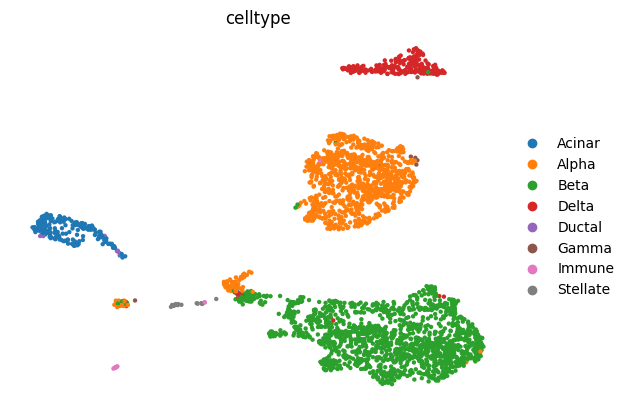

Silhouette Coefficient in PCA space: 0.23544558882713318


In [17]:
edge_adata.X = np.maximum(edge_adata.X, 0)

# Loading the data
adata = edge_adata.copy()  # Assuming this is your RNA-seq data

# Normalize for sequencing depth (total-count normalization)
sc.pp.normalize_total(adata, target_sum=1e4)  # Normalize to 10,000 reads per cell

# Log-transformation of the data (common for RNA-seq)
sc.pp.log1p(adata)  # Log-transform the data after normalization

# Identifying highly variable genes
sc.pp.highly_variable_genes(adata, n_top_genes=10000, flavor="seurat")

# Subset the adata to only highly variable genes
adata = adata[:, adata.var.highly_variable]

# Scaling the data (optional, but often useful for PCA and clustering)
sc.pp.scale(adata, max_value=10)

# Running PCA to reduce dimensions
sc.tl.pca(adata, svd_solver="arpack", n_comps=30)

# Finding neighbors for clustering (based on PCA components)
sc.pp.neighbors(adata, n_neighbors=20, n_pcs=30, metric="cosine")

# Running UMAP for visualization
sc.tl.umap(adata, min_dist=0.5)

# Visualizing the UMAP plot with color based on 'celltype'
sc.pl.umap(adata, color=["celltype"], wspace=0.5, frameon=False)

# Calculate the silhouette score using PCA embeddings
pca_embeddings = adata.obsm["X_pca"]
silhouette_score_value = silhouette_score(
    pca_embeddings, adata.obs["celltype"], metric="cosine"
)

# Printing the silhouette score
print("Silhouette Coefficient in PCA space:", silhouette_score_value)

In [18]:
num_cell_types = len(np.unique(adata.obs.celltype))

Adjusted Rand Index (ARI): 0.3963
真实细胞类型分布:
celltype
Beta        1512
Alpha       1052
Delta        220
Acinar       181
Stellate      17
Immune        15
Ductal        11
Gamma          9
Name: count, dtype: int64

优化后聚类分布:
kmeans_optimized
2    855
1    720
3    614
7    243
6    206
5    193
0    152
4     34
Name: count, dtype: int64


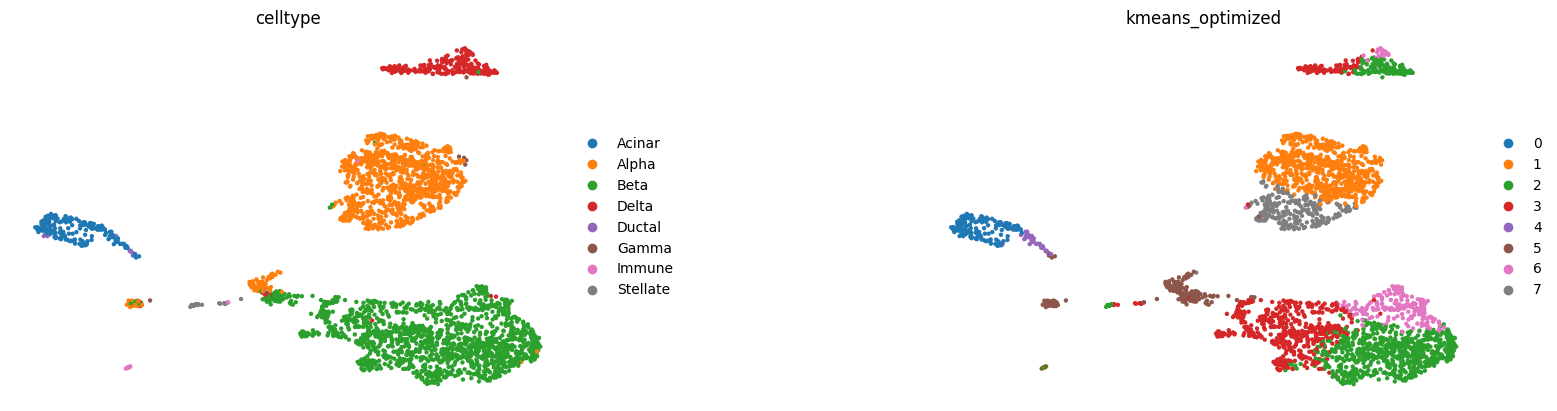

In [19]:
edge_adata.X = np.maximum(edge_adata.X, 0)

# 加载数据
adata = edge_adata.copy()

# 数据预处理
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=10000, flavor="seurat")
adata = adata[:, adata.var.highly_variable]
sc.pp.scale(adata, max_value=10)

# 运行PCA降维
sc.tl.pca(adata, svd_solver="arpack", n_comps=30)

# 使用K-means进行聚类，固定类别数
kmeans = KMeans(n_clusters=num_cell_types, random_state=42)
cluster_labels = kmeans.fit_predict(adata.obsm["X_pca"])


# 匈牙利算法匹配标签
def hungarian_algorithm_match(true_labels, pred_labels):
    # 创建混淆矩阵
    true_codes = pd.Categorical(true_labels).codes
    pred_codes = pd.Categorical(pred_labels).codes

    n_true = len(np.unique(true_codes))
    n_pred = len(np.unique(pred_codes))

    # 构建混淆矩阵
    contingency_matrix = np.zeros((n_true, n_pred))
    for i in range(len(true_codes)):
        contingency_matrix[true_codes[i], pred_codes[i]] += 1

    # 使用匈牙利算法找到最优匹配
    row_ind, col_ind = linear_sum_assignment(-contingency_matrix)

    # 创建映射字典
    mapping = {pred: true for true, pred in zip(row_ind, col_ind)}

    # 重新映射预测标签
    remapped_labels = np.array([mapping[label] for label in pred_codes])

    return remapped_labels


# 获取真实标签
true_labels = adata.obs["celltype"]

# 用匈牙利算法匹配并重新映射预测标签
optimized_pred_labels = hungarian_algorithm_match(true_labels, cluster_labels)

# 计算ARI
ari_score = adjusted_rand_score(
    pd.Categorical(true_labels).codes, optimized_pred_labels
)

print(f"Adjusted Rand Index (ARI): {ari_score:.4f}")

# 可选：将优化后的聚类结果添加到adata中
adata.obs["kmeans_optimized"] = optimized_pred_labels.astype(str)

# 可视化比较
sc.pp.neighbors(adata, n_neighbors=20, n_pcs=30, metric="cosine")
sc.tl.umap(adata, min_dist=0.5)

print("真实细胞类型分布:")
print(adata.obs["celltype"].value_counts())
print("\n优化后聚类分布:")
print(adata.obs["kmeans_optimized"].value_counts())

# 可视化
sc.pl.umap(adata, color=["celltype", "kmeans_optimized"], wspace=0.5, frameon=False)

In [20]:
print("ARI:", ari_score)
print("SI score:", silhouette_score_value)
print("celltype:", cell_types)
print("rr_auc:", auc_scores_by_cell_type)
print("mean:", np.mean(auc_scores_by_cell_type))

# 保存结果到log文件
# 准备结果数据
log_data = {
    "experiment": "Head1",  # 实验名称
    "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "ARI": float(ari_score),
    "SI_score": float(silhouette_score_value),
    "celltype": str(cell_types),
    "rr_auc": [float(x) for x in auc_scores_by_cell_type],
    "mean_auc": float(np.mean(auc_scores_by_cell_type)),
}

# # 保存到JSON文件（追加模式）
# log_file = "../output_343206/Pan_ablation_results.jsonl"
# with open(log_file, "a", encoding="utf-8") as f:
#     f.write(json.dumps(log_data, ensure_ascii=False) + "\n")

# print("结果已保存到:", log_file)

ARI: 0.3962611870721627
SI score: 0.23544558882713318
celltype: ['Acinar', 'Alpha', 'Beta']
rr_auc: [0.7990777789177297, 0.6879291395181673, 0.6504116845247916]
mean: 0.7124728676535629


In [21]:
predicted_gene_expression, test_barcodes, cell_type = get_gene_expression(
    dataset_atac, model, test_graph, batch_size=20, device=device
)
df_predicted_rna = pd.DataFrame(
    predicted_gene_expression,
    index=dataset_atac.adata[test_barcodes].obs_names,
    columns=dataset_atac.array_peak[: len(dataset_atac.df_rna.columns)],
)
df_predicted_rna["celltype"] = dataset_atac.adata[test_barcodes].obs.celltype.values
# 假设 dataset_atac.list_graph 是一个列表，每个元素是一个 Data 对象
cell_barcodes = []
true_expression_values = []

for graph_data in dataset_atac.list_graph:
    cell_barcodes.append(graph_data.cell)  # 提取 cell 名称
    true_expression_values.append(
        graph_data.y_exp.cpu().numpy()
    )  # 提取表达量向量，转为 numpy

# 创建 DataFrame
df_true_rna = pd.DataFrame(true_expression_values, index=cell_barcodes)
df_true_rna.index = dataset_atac.adata[df_true_rna.index,].obs_names
df_true_rna.columns = dataset_atac.array_peak[: len(df_true_rna.columns)]

df_true_rna = df_true_rna.loc[df_predicted_rna.index,]
df_true_rna["celltype"] = dataset_atac.adata[df_true_rna.index].obs.celltype.values
df_true_rna.head()

# path_1 = f"../output_343206/Pan_head1_Pre_exp.csv"
# df_predicted_rna.to_csv(path_1)
# path_2 = f"../output_343206/Pan_head1_True_exp.csv"
# df_true_rna.to_csv(path_2)

Processing Batches: 100%|██████████| 151/151 [00:11<00:00, 13.70it/s]


,GNB1,PRDM16,NPHP4,KCNAB2,PER3,RERE,SPSB1,PIK3CD,DHRS3,IFFO2,...,DOCK11,GRIA3,GPC4,MAMLD1,CD99L2,RPL10,DDX3Y,UTY,NLGN4Y,celltype
C0027_AAACAGCCACACTAAT-1,0.000000,0.0,0.000,0.0,0.0,0.003132,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.003132,0.000000,Beta
C0027_AAACAGCCATGAGTTT-1,0.001563,0.0,0.000,0.0,0.0,0.003125,0.0,0.0,0.0,0.0,...,0.0,0.001563,0.0,0.001563,0.000000,0.0,0.001563,0.000000,0.003125,Alpha
C0027_AAACATGCACTGGCTG-1,0.000817,0.0,0.000,0.0,0.0,0.004902,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000817,0.000817,0.0,0.000817,0.008170,0.000000,Beta
C0027_AAACATGCAGGACACA-1,0.001682,0.0,0.000,0.0,0.0,0.004484,0.0,0.0,0.0,0.0,...,0.0,0.000561,0.0,0.000000,0.000561,0.0,0.003363,0.004484,0.000000,Beta
C0027_AAACATGCATAAGTCT-1,0.000000,0.0,0.001,0.0,0.0,0.005000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.009000,0.000000,Beta


In [22]:
df_predicted_rna.head()

,GNB1,PRDM16,NPHP4,KCNAB2,PER3,RERE,SPSB1,PIK3CD,DHRS3,IFFO2,...,DOCK11,GRIA3,GPC4,MAMLD1,CD99L2,RPL10,DDX3Y,UTY,NLGN4Y,celltype
C0027_AAACAGCCACACTAAT-1,0.009075,0.020006,0.011542,0.011666,0.010807,0.014875,0.014625,0.015024,0.022620,0.009921,...,0.009486,0.020807,0.025044,0.024893,0.012718,0.013999,0.007485,0.007720,0.024844,Beta
C0027_AAACAGCCATGAGTTT-1,0.009889,0.009552,0.010304,0.010574,0.009420,0.010843,0.008703,0.011828,0.014254,0.011731,...,0.025580,0.022305,0.017007,0.011327,0.012106,0.012244,0.007665,0.006061,0.025580,Alpha
C0027_AAACATGCACTGGCTG-1,0.008752,0.012092,0.010708,0.010138,0.009192,0.010901,0.009224,0.013623,0.017858,0.008597,...,0.009729,0.022304,0.016848,0.022745,0.011870,0.011132,0.025580,0.025580,0.007604,Beta
C0027_AAACATGCAGGACACA-1,0.011432,0.015037,0.017504,0.020538,0.015000,0.013237,0.010648,0.014045,0.023255,0.017891,...,0.009023,0.025580,0.025580,0.021878,0.020100,0.014124,0.008690,0.011746,0.025580,Beta
C0027_AAACATGCATAAGTCT-1,0.008058,0.007215,0.010588,0.011763,0.007213,0.007730,0.007498,0.010272,0.011552,0.009211,...,0.005337,0.009892,0.025580,0.012233,0.010993,0.007534,0.009495,0.009413,0.025580,Beta
